In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv

from tensorflow.keras.layers import Dense, SimpleRNN, Input, Embedding, Flatten, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

In [2]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/contur_test/train.txt'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/contur_test/test.txt'
RESULT_PATH = '/content/drive/MyDrive/Colab Notebooks/contur_test/result.txt'

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep='\t', names=['name'], quoting=csv.QUOTE_NONE)

## EDA

Разобъем наименования на слова.
Используем в качестве разделителя ' ', '-' и '.'
Разделим слова на 4 класса: 

0.   Все символы с большой буквы
1.   Все символы с маленькой буквы
2.   Слова начинающиеся с заглавной буквы
3.   Смешанные регистры



In [7]:
df_train = pd.DataFrame(df_train['name'].str.split(r' *- *| +| *\. *').explode())
df_train['type'] = -1
df_train = df_train.reset_index()
df_train.replace({'name': r'[^A-Za-zА-Яа-я]+'}, {'name': ''}, regex=True, inplace=True)
df_train.loc[df_train['name'].str.isupper(), 'type'] = 0
df_train.loc[df_train['name'].str.islower(), 'type'] = 1
df_train.loc[df_train['name'].str.istitle(), 'type'] = 2
df_train.loc[(df_train['name'].str.isalpha()) & (df_train['type'] == -1), 'type'] = 3
df_train = df_train.loc[~(df_train['name'] == '')]

In [8]:
df_train['type'].value_counts()

1    16141481
2    11423745
0     3362310
3      398455
Name: type, dtype: int64

Имеется дисбаланс классов, при этом смешанный регистр встречается реже всех

Построим распределение слов по длинам

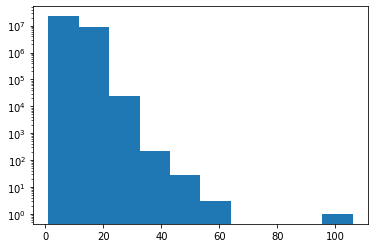

In [12]:
plt.hist(list(map(len, df_train['name'])), log=True)
plt.show()

Слова в наименованиях длиной более 50 встречаются довольно редко, поэтому можно попробовать ограничить длину векторов 50 символами

## Предобработка данных для обучения

In [3]:
class Data_pipeline:
  def __init__(self):
    self.tokenizer = None

  def fit(self, df, max_word_len=50):
    maxWordsCount = 60
    self.tokenizer = Tokenizer(num_words=maxWordsCount, lower=True, char_level=True)
    self.tokenizer.fit_on_texts(df_train['name'])

    self.max_word_len = max_word_len

  def transform_df(self, df):
    df = pd.DataFrame(df['name'].str.split(r' *- *| +| *\. *').explode())
    df['type'] = -1
    df = df.reset_index()

    df.replace({'name': r'[^A-Za-zА-Яа-я"]+'}, {'name': ''}, regex=True, inplace=True)
    df.loc[df['name'].str.isupper(), 'type'] = 0
    df.loc[df['name'].str.islower(), 'type'] = 1
    df.loc[df['name'].str.istitle(), 'type'] = 2
    df.loc[(df['name'].str.isalpha()) & (df['type'] == -1), 'type'] = 3
    df = df.loc[~(df['name'] == '')]
    return df, len(df)

  def generate(self, df, batch_size):
    X_batch = []
    Y_batch = []
    while True:
      for line, answer in zip(df['name'], df['type']):
        X_batch.append(line)
        Y_batch.append(answer)

        if len(X_batch) == batch_size:
          yield pad_sequences(self.tokenizer.texts_to_sequences(X_batch), maxlen=self.max_word_len), to_categorical(Y_batch, num_classes=4, dtype='int32')
          X_batch.clear()
          Y_batch.clear()
      
  def transform(self, word):
    return pad_sequences(np.array(self.tokenizer.texts_to_sequences(word)), maxlen=self.max_word_len)
    

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep='\t', names=['name'], quoting=csv.QUOTE_NONE)
X_train, X_test = train_test_split(df_train, test_size=0.2, random_state=42)

pipeline = Data_pipeline()
pipeline.fit(X_train, max_word_len=50)

X_train, train_len = pipeline.transform_df(X_train)
X_test, test_len = pipeline.transform_df(X_test)

## Обучение модели

In [5]:
model = Sequential()
model.add(Embedding(60, 10, input_length=50,))
model.add(Flatten())
model.add(Dense(units=80, activation='relu'))
model.add(Dense(4,  activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 10)            600       
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 80)                40080     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 324       
Total params: 41,004
Trainable params: 41,004
Non-trainable params: 0
_________________________________________________________________


In [6]:
batch_size = 5000
his = model.fit_generator(pipeline.generate(X_train, batch_size), 
                          steps_per_epoch = train_len // batch_size,
                          epochs=8,
                          validation_data = pipeline.generate(X_test, batch_size),
                          validation_steps = test_len // batch_size
                          )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
5061/5061 [==============================] - 524s 103ms/step - loss: 0.4588 - accuracy: 0.8211 - val_loss: 0.3393 - val_accuracy: 0.8727
Epoch 2/8
5061/5061 [==============================] - 530s 105ms/step - loss: 0.3364 - accuracy: 0.8735 - val_loss: 0.3284 - val_accuracy: 0.8770
Epoch 3/8
5061/5061 [==============================] - 529s 105ms/step - loss: 0.3282 - accuracy: 0.8766 - val_loss: 0.3243 - val_accuracy: 0.8784
Epoch 4/8
5061/5061 [==============================] - 489s 97ms/step - loss: 0.3243 - accuracy: 0.8782 - val_loss: 0.3227 - val_accuracy: 0.8783
Epoch 5/8
5061/5061 [==============================] - 488s 97ms/step - loss: 0.3220 - accuracy: 0.8790 - val_loss: 0.3207 - val_accuracy: 0.8796
Epoch 6/8
5061/5061 [==============================] - 493s 98ms/step - loss: 0.3205 - accuracy: 0.8795 - val_loss: 0.3204 - val_accuracy: 0.8791
Epoch 7/8
5061/5061 [==============================] - 501s 99ms/step - loss: 0.3195 - accuracy: 0.8799 - val_loss: 0.320

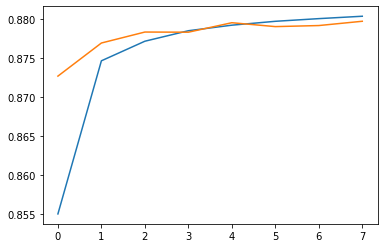

In [7]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])

## Постобработка результатов

In [8]:
class Predictor:
  def __init__(self):
    self.predictions = None
  
  def get_true_reg(self, df):
    self.predictions = self._predict(df)
    self.readed = 0
    df['result'] = df.apply(lambda row : re.sub(r'[A-Za-zА-Яа-я]+', self._change_reg, row['name']), axis=1)
    return df

  def _predict(self, df):
    matches = []
    for line in df['name']:
      matches.extend(re.findall(r'[A-Za-zА-Яа-я]+', line))

    return np.argmax(model.predict(pipeline.transform(matches)), axis=1)

  def _change_reg(self, match):
    word = match.group()
    reg_index = self.predictions[self.readed]
    self.readed += 1
    if reg_index == 0:
      return word.upper()
    elif reg_index == 1:
      return word.lower()
    elif reg_index == 2:
      return word.title()
    elif reg_index == 3:
      return word

## Submition results

In [9]:
df_test = pd.read_csv(TEST_DATASET_PATH, sep='\t', names=['name'], quoting=csv.QUOTE_NONE)
pred = Predictor()
df_test = pred.get_true_reg(df_test)
df_test.to_csv(RESULT_PATH, sep='\t', columns=['result'], header=False, index=False, quoting=csv.QUOTE_NONE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
